In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ase.io import read
from ase.visualize import view
import matplotlib.pyplot as plt
import numpy as np 
import torch 
torch.set_default_dtype(torch.float64)

import rascaline

import metatensor 
from metatensor import Labels, TensorBlock, TensorMap
from metatensor import load, sort

from mlelec.data.dataset import PySCFPeriodicDataset, split_by_Aij_mts
from mlelec.utils.twocenter_utils import _to_coupled_basis
from mlelec.utils.pbc_utils import matrix_to_blocks, kmatrix_to_blocks, TMap_bloch_sums, precompute_phase, kblocks_to_matrix, kmatrix_to_blocks, blocks_to_matrix, matrix_to_blocks
from mlelec.utils.plot_utils import print_matrix, matrix_norm, block_matrix_norm, plot_block_errors
from mlelec.features.acdc import pair_features, single_center_features, twocenter_features_periodic_NH, twocenter_hermitian_features
from mlelec.models.linear import LinearModelPeriodic

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [3]:
def get_targets(dataset, device ="cpu", cutoff = None, target='fock', all_pairs = False, sort_orbs = True):
    
    blocks = matrix_to_blocks(dataset, device = device, cutoff = cutoff, all_pairs = all_pairs, target = target, sort_orbs = sort_orbs)
    coupled_blocks = _to_coupled_basis(blocks, skip_symmetry = True, device = device, translations = True)

    blocks = blocks.to(arrays='numpy')
    blocks = sort(blocks)
    blocks = blocks.to(arrays='torch')
    
    coupled_blocks = coupled_blocks.to(arrays='numpy')
    coupled_blocks = sort(coupled_blocks)
    coupled_blocks = coupled_blocks.to(arrays='torch')
    
    return blocks, coupled_blocks

In [4]:
def compute_features(dataset, all_pairs=False):

    rhoij = pair_features(dataset.structures, hypers_atom, hypers_pair, order_nu = 1, all_pairs = all_pairs, both_centers = both_centers,
                          kmesh = dataset.kmesh, device = device, lcut = LCUT, return_rho0ij = return_rho0ij)  
    
    if both_centers and not return_rho0ij:
        NU = 3
    else:
        NU = 2
    rhonui = single_center_features(dataset.structures, hypers_atom, order_nu = NU, lcut = LCUT, device = device,
                                    feature_names = rhoij.property_names)
    
    hfeat = twocenter_features_periodic_NH(single_center = rhonui, pair = rhoij, all_pairs = all_pairs)

    return hfeat

In [5]:
device = 'cpu'

orbitals = {
    'sto-3g': {5: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               6: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 
               7: [[1,0,0],[2,0,0],[2,1,-1], [2,1,0],[2,1,1]]}, 
    
    'def2svp': {6: [[1,0,0],[2,0,0],[3,0,0],[2,1,1], [2,1,-1],[2,1,0], [3,1,1], [3,1,-1],[3,1,0], [3,2,-2], [3,2,-1],[3,2,0], [3,2,1],[3,2,2]]},
    'benzene': {6: [[2,0,0],[2,1,-1], [2,1,0],[2,1,1]], 1:[[1,0,0]]},
    'gthszvmolopt': {
        6: [[2, 0, 0], [2, 1, -1], [2, 1, 0], [2, 1, 1]],
        
        16: [[3,0,0], 
             [3,1,-1], [3,1,0], [3,1,1]],

        42: [[4,0,0], 
             [5,0,0], 
             [4,1,-1], [4,1,0], [4,1,1], 
             [4, 2, -2], [4, 2, -1], [4, 2, 0], [4, 2, 1], [4, 2, 2]]}
}

# QC dataset

In [6]:
workdir = './'
START = 0 
STOP = 10
ORBS = 'sto-3g'
root = f'{workdir}/examples/data/periodic/deepH_graphene/wrap/'
data_dir = root
frames = read(f'{data_dir}/wrapped_deepH_graphene.xyz', slice(START, STOP))
rfock = [np.load(f"{data_dir}/realfock_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
rover = [np.load(f"{data_dir}/realoverlap_{i}.npy", allow_pickle = True).item() for i in range(START, STOP)]
kmesh = [1,1,1]
dataset = PySCFPeriodicDataset(frames = frames, 
                               kmesh = kmesh, 
                               dimension = 2,
                               fock_realspace = rfock, 
                               overlap_realspace = rover, 
                               device = device, 
                               orbs = orbitals[ORBS], 
                               orbs_name = 'sto-3g')

# Targets

In [7]:
cutoff = 6

In [8]:
target_blocks, target_coupled_blocks = get_targets(dataset, cutoff = cutoff, device = device)

In [25]:
k_target_blocks = kmatrix_to_blocks(dataset, cutoff = cutoff)
k_target_coupled_blocks = _to_coupled_basis(kmatrix_to_blocks(dataset, cutoff = cutoff), skip_symmetry = True, device = device, translations= False)

In [11]:
phase, indices, kpts_idx = precompute_phase(target_coupled_blocks, dataset, cutoff = cutoff)
pred_k = TMap_bloch_sums(target_coupled_blocks, phase, indices, kpts_idx, return_tensormap = True)

# Features

In [294]:
max_radial  = 6
max_angular = 4
atomic_gaussian_width = 0.3

hypers_pair = {'cutoff': cutoff,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': atomic_gaussian_width,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}


hypers_atom = {'cutoff': 4,
               'max_radial': max_radial,
               'max_angular': max_angular,
               'atomic_gaussian_width': 0.3,
               'center_atom_weight': 1,
               "radial_basis": {"Gto": {}},
               "cutoff_function": {"ShiftedCosine": {"width": 0.1}}}


return_rho0ij = False
both_centers = False
LCUT = 3

In [295]:
features = compute_features(dataset)

cpu pair features
cpu single center features
cpu single center features


# ML Dataset/Dataloader

In [11]:
from metatensor.learn import Dataset, DataLoader, IndexedDataset
from metatensor.learn.data import group as mts_group, group_and_join as group_and_join_mts
import metatensor as mts
from mlelec.data.dataset import split_by_Aij

In [62]:
%%timeit -n 1 -r 10
split_features_mts, split_target_mts = split_by_Aij_mts(target_coupled_blocks, features = features)

4.78 s ± 1.01 s per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [63]:
%%timeit -n 1 -r 10
split_features, split_target = split_by_Aij(target_coupled_blocks, features = features)

248 ms ± 725 µs per loop (mean ± std. dev. of 10 runs, 1 loop each)


In [59]:
split_features, split_target = split_by_Aij(target_coupled_blocks, features = features)

## Using tensormaps

In [65]:
split_features, split_target = split_by_Aij_mts(target_coupled_blocks, features = features)

In [66]:
ml_data = IndexedDataset(descriptor = list(split_features.values()), target = list(split_target.values()), sample_id = list(split_target.keys()))

In [111]:
batch_size = 20
dataloader = DataLoader(ml_data, batch_size = batch_size, shuffle = True, collate_fn = lambda x: group_and_join_mts(x, join_kwargs = {'different_keys': 'union', 'remove_tensor_name': True}))

In [92]:
phase, indices, kpts_idx = precompute_phase(target_coupled_blocks, dataset, cutoff = cutoff)

In [112]:
kmap = []
for batch in dataloader:
    kmap.append(TMap_bloch_sums(batch.target, phase, indices, kpts_idx, return_tensormap = True))

## Metatensor native splitting by structure

In [296]:
split_by_axis = "samples"
split_by_dimension = "structure"

grouped_labels = [mts.Labels(names = split_by_dimension, values = np.array([A])) for A in mts.unique_metadata(target_coupled_blocks, axis = split_by_axis, names = split_by_dimension)]
split_target = mts.split(target_coupled_blocks, split_by_axis, grouped_labels)

grouped_labels = [mts.Labels(names = split_by_dimension, values = np.array([A])) for A in mts.unique_metadata(features, axis = split_by_axis, names = split_by_dimension)]
split_features = mts.split(features, split_by_axis, grouped_labels)

In [297]:
ml_data = IndexedDataset(descriptor = split_features, target = split_target, sample_id = [g.values.tolist()[0][0] for g in grouped_labels])

Split kspace targets

In [298]:
split_by_axis = "samples"
split_by_dimension = "structure"

grouped_labels = [mts.Labels(names = split_by_dimension, values = np.array([A])) for A in mts.unique_metadata(k_target_coupled_blocks, axis = split_by_axis, names = split_by_dimension)]
split_target_k = mts.split(k_target_coupled_blocks, split_by_axis, grouped_labels)

grouped_labels = [mts.Labels(names = split_by_dimension, values = np.array([A])) for A in mts.unique_metadata(features, axis = split_by_axis, names = split_by_dimension)]
split_features_k = mts.split(features, split_by_axis, grouped_labels)

In [299]:
ml_data_k = IndexedDataset(descriptor = split_features_k, target = split_target_k, sample_id = [g.values.tolist()[0][0] for g in grouped_labels])

# Train

In [10]:
from mlelec.metrics import L2_loss, L2_kspace_loss
from mlelec.utils.twocenter_utils import _to_uncoupled_basis, map_targetkeys_to_featkeys
from mlelec.utils.pbc_utils import precompute_phase, TMap_bloch_sums

In [301]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)

model = LinearModelPeriodic(twocfeat = features, 
                            target_blocks = target_coupled_blocks,
                            frames = dataset.structures, orbitals = dataset.basis, 
                            device = device,
                            bias = True,
                            nhidden = 128, 
                            nlayers = 1,
                            activation = 'SiLU',
                            apply_norm = True
                           )
model = model.double()

nepoch = 1000

optimizers = []
schedulers = []
for i, key in enumerate(model.model):
    optimizers.append(torch.optim.AdamW(model.model[key].parameters(), lr = 1e-3, betas = (0.8, 0.9)))
    schedulers.append(torch.optim.lr_scheduler.ReduceLROnPlateau(optimizers[-1], factor = 0.8, patience = 30, verbose=True))

/home/pegolo/micromamba/envs/sci/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [302]:
phase, indices, kpts_idx = precompute_phase(target_coupled_blocks, dataset, cutoff = cutoff)

In [303]:
batch_size = 1
dataloader = DataLoader(ml_data, batch_size = batch_size, shuffle = False, collate_fn = lambda x: group_and_join_mts(x, join_kwargs = {'different_keys': 'union', 'remove_tensor_name': True}))
dataloader_k = DataLoader(ml_data_k, batch_size = batch_size, shuffle = False, collate_fn = lambda x: group_and_join_mts(x, join_kwargs = {'different_keys': 'union', 'remove_tensor_name': True}))

In [304]:
# %%timeit -n 1 -r 1

train_kspace = False
LOSS_LIST = []

nepoch = 100
for epoch in range(nepoch):

    if epoch >= 50:
        train_kspace = True

    if not train_kspace:
        # Train against real space targets
        LOSS = 0
        for ib, batch in enumerate(dataloader):
            
            model.train(True)
            
            for ik, key in enumerate(model.model):
                optimizers[ik].zero_grad()
            
            pred = model.predict_batch(batch.descriptor, batch.target)
            
            # Compute the loss for each block
            all_losses, epoch_loss = L2_loss(pred, batch.target, loss_per_block = True)
    
            # Total loss
            epoch_loss = epoch_loss.item()
            LOSS += epoch_loss
    
            # Loop through submodels and backpropagate
            for ik, (loss, key) in enumerate(zip(all_losses, model.model)):
                loss.backward(retain_graph = False)
                torch.nn.utils.clip_grad_norm_(model.model[key].parameters(), 1)
                optimizers[ik].step()
                schedulers[ik].step(loss)

    else:
        # Train against k-space targets
    
        LOSS = 0
        for ib, batch in enumerate(dataloader_k):

            model.train(True)
    
            for ik, key in enumerate(model.model):
                optimizers[ik].zero_grad()
            
            pred = model.predict_batch(batch.descriptor)
            pred_kspace = TMap_bloch_sums(pred, phase, indices, kpts_idx, return_tensormap = True)
            
            # Compute the loss
            loss = L2_loss(pred_kspace, batch.target, norm = 2)
    
            # Total loss 
            epoch_loss = loss.item()
            LOSS += epoch_loss
                   
            loss.backward(retain_graph = True)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    
            for ik, key in enumerate(model.model):
                optimizers[ik].step()
                schedulers[ik].step(epoch_loss/len(model.model))

    if epoch >= 0: #% 10 == 0:
        # print(f"Epoch {epoch:>7d}, train loss on all blocks {epoch_loss:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")
        # print(f"Epoch {epoch:>7d}, train loss real {loss_real[-1]:>15.10f}") #, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")
        LOSS_LIST.append(LOSS)
        print(f"Epoch {epoch:>7d}, train loss {LOSS:>15.10f}") #, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")

Epoch       0, train loss 64099.8212522554
Epoch       1, train loss 44150.1930657664
Epoch       2, train loss 26674.6991637603
Epoch       3, train loss 10917.7301031400
Epoch       4, train loss 1464.4126782936
Epoch       5, train loss  145.1177953997
Epoch       6, train loss   30.6126823539
Epoch       7, train loss   19.7077010330
Epoch       8, train loss   15.4932212290
Epoch       9, train loss   15.4773647876
Epoch      10, train loss   13.6507310172
Epoch      11, train loss   13.0167951003
Epoch      12, train loss   15.8249425456
Epoch      13, train loss    7.5995894473
Epoch      14, train loss    6.9821789883
Epoch      15, train loss    5.6214293910
Epoch      16, train loss    5.3257322724
Epoch      17, train loss    5.7309572868
Epoch      18, train loss    4.5858151378
Epoch      19, train loss    5.0811340728
Epoch      20, train loss    3.5698208473
Epoch      21, train loss    4.8419821021
Epoch      22, train loss    4.8125507777
Epoch      23, train loss    2

/home/pegolo/Software/mlelec/src/mlelec/models/linear.py:574: UserWarning: Using train target_blocks, otherwise provide test target_blocks
  warnings.warn('Using train hfeat, otherwise provide test hfeat')


Epoch      50, train loss    1.0668415374
Epoch      51, train loss    1.3058728456
Epoch      52, train loss    0.5429070372
Epoch      53, train loss    0.5534921993
Epoch      54, train loss    0.5043684919
Epoch      55, train loss    0.4577762065
Epoch      56, train loss    0.5248318676
Epoch      57, train loss    0.4451914575
Epoch      58, train loss    0.3486237178
Epoch      59, train loss    0.2837883841
Epoch      60, train loss    0.2686054429
Epoch      61, train loss    0.2645887641
Epoch      62, train loss    0.2408161128
Epoch      63, train loss    0.2389337685
Epoch      64, train loss    0.2322626037
Epoch      65, train loss    0.2169345446
Epoch      66, train loss    0.2111775954
Epoch      67, train loss    0.2091001209
Epoch      68, train loss    0.2004720243
Epoch      69, train loss    0.1929587508
Epoch      70, train loss    0.1920110071
Epoch      71, train loss    0.1892915645
Epoch      72, train loss    0.2062768902
Epoch      73, train loss    0.198

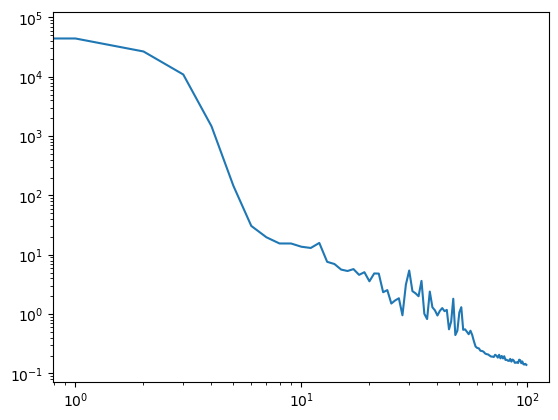

In [306]:
plt.loglog(LOSS_LIST)

In [44]:
# %%timeit -n 1 -r 1

new_sched = True

train_kspace = False

loss_real = []

nepoch = 100
for epoch in range(nepoch):

    if epoch >= 0:
        train_kspace = True

    LOSS = 0
    for ib, batch in enumerate(dataloader):

        model.train(True)

        for ik, key in enumerate(model.model):
            optimizers[ik].zero_grad()
        
        pred = model.predict_batch(batch.descriptor, batch.target)
            
        if not train_kspace:
    
            # Compute the loss for each block
            all_losses, epoch_loss = L2_loss(pred, batch.target, loss_per_block = True)
    
            # Total loss
            epoch_loss = epoch_loss.item()
            LOSS += epoch_loss
            # Append the values of the loss to a list
            # loss_k.append(L2_loss(pred_kspace, k_target_blocks, norm = 2).item())
            loss_real.append(epoch_loss)
    
            # Loop through submodels and backpropagate
            for ik, (loss, key) in enumerate(zip(all_losses, model.model)):
                loss.backward(retain_graph = False)
                torch.nn.utils.clip_grad_norm_(model.model[key].parameters(), 1)
                optimizers[ik].step()
                schedulers[ik].step(loss)
                
                if key not in losses:
                    losses[key] = [loss.item()]
                    learning_rates[key] = [schedulers[ik].state_dict()['_last_lr'][0]]
                else:
                    losses[key].append(loss.item())
                    learning_rates[key].append(schedulers[ik].state_dict()['_last_lr'][0])
                    
        else:

            pred_kspace = TMap_bloch_sums(pred, phase, indices, kpts_idx, return_tensormap = True)
            target_kspace = TMap_bloch_sums(batch.target, phase, indices, kpts_idx, return_tensormap = True)
            
            # Compute the loss
            loss = L2_loss(pred_kspace, target_kspace, norm = 2)
    
            # Total loss 
            epoch_loss = loss.item()
            LOSS += epoch_loss
            
            # Append the values of the loss to a list
            all_losses, epoch_loss_real = L2_loss(pred, batch.target, loss_per_block=True)
            # loss_real.append(epoch_loss_real.item())
            # loss_k.append(epoch_loss)
    
                   
            loss.backward(retain_graph = True)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
    
            # for ik, (loss_, key) in enumerate(zip(all_losses, model.model)):
            for ik, key in enumerate(model.model):
                optimizers[ik].step()
                schedulers[ik].step(epoch_loss/len(model.model))
                # if key not in losses:
                #     # losses[key] = [loss_.item()]
                #     learning_rates[key] = [schedulers[ik].state_dict()['_last_lr'][0]]
                # else:
                #     # losses[key].append(loss_.item())
                #     learning_rates[key].append(schedulers[ik].state_dict()['_last_lr'][0])

        # print(ib, end = ' ')
    if epoch >= 0: #% 10 == 0:
        # print(f"Epoch {epoch:>7d}, train loss on all blocks {epoch_loss:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")
        # print(f"Epoch {epoch:>7d}, train loss real {loss_real[-1]:>15.10f}") #, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")
        print(f"Epoch {epoch:>7d}, train loss real {LOSS:>15.10f}") #, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")

Epoch       0, train loss real  593.0036468974
Epoch       1, train loss real   49.2449186928
Epoch       2, train loss real    2.0704940922
Epoch       3, train loss real    0.6410718528


KeyboardInterrupt: 

In [46]:
target_kspace = TMap_bloch_sums(target_coupled_blocks, phase, indices, kpts_idx, return_tensormap = True)

In [47]:
# %%timeit -r 1 -n 1

new_sched = True

# batch_size = 360
# dataloader = DataLoader(ml_data, batch_size = batch_size, shuffle = True, collate_fn = lambda x: group_and_join_mts(x, join_kwargs = {'different_keys': 'union', 'remove_tensor_name': True}))

train_kspace = False

# target_kspace = 
loss_real = []

nepoch = 100
for epoch in range(nepoch):

    if epoch >= 0:
        train_kspace = True

    model.train(True)

    for ik, key in enumerate(model.model):
        optimizers[ik].zero_grad()
    
    pred = model()
        
    if not train_kspace:

        # Compute the loss for each block
        all_losses, epoch_loss = L2_loss(pred, target_coupled_blocks, loss_per_block = True)

        # Total loss
        epoch_loss = epoch_loss.item()
        LOSS = epoch_loss
        # Append the values of the loss to a list
        # loss_k.append(L2_loss(pred_kspace, k_target_blocks, norm = 2).item())
        loss_real.append(epoch_loss)

        # Loop through submodels and backpropagate
        for ik, (loss, key) in enumerate(zip(all_losses, model.model)):
            loss.backward(retain_graph = False)
            torch.nn.utils.clip_grad_norm_(model.model[key].parameters(), 1)
            optimizers[ik].step()
            schedulers[ik].step(loss)
            
            if key not in losses:
                losses[key] = [loss.item()]
                learning_rates[key] = [schedulers[ik].state_dict()['_last_lr'][0]]
            else:
                losses[key].append(loss.item())
                learning_rates[key].append(schedulers[ik].state_dict()['_last_lr'][0])
                
    else:

        pred_kspace = TMap_bloch_sums(pred, phase, indices, kpts_idx, return_tensormap = True)
        # target_kspace = TMap_bloch_sums(batch.target, phase, indices, kpts_idx, return_tensormap = True)
        
        # Compute the loss
        loss = L2_loss(pred_kspace, target_kspace, norm = 2)

        # Total loss 
        epoch_loss = loss.item()
        LOSS = epoch_loss        
        # Append the values of the loss to a list
        all_losses, epoch_loss_real = L2_loss(pred, target_coupled_blocks, loss_per_block=True)
        # loss_real.append(epoch_loss_real.item())
        # loss_k.append(epoch_loss)

               
        loss.backward(retain_graph = True)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        for ik, (loss_, key) in enumerate(zip(all_losses, model.model)):
            optimizers[ik].step()
            schedulers[ik].step(epoch_loss/len(model.model))
            if key not in losses:
                losses[key] = [loss_.item()]
                learning_rates[key] = [schedulers[ik].state_dict()['_last_lr'][0]]
            else:
                losses[key].append(loss_.item())
                learning_rates[key].append(schedulers[ik].state_dict()['_last_lr'][0])

    # print(ib, end = ' ')
    if epoch >= 0: #% 10 == 0:
        # print(f"Epoch {epoch:>7d}, train loss on all blocks {epoch_loss:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")
        # print(f"Epoch {epoch:>7d}, train loss real {loss_real[-1]:>15.10f}") #, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")
        print(f"Epoch {epoch:>7d}, train loss real {LOSS:>15.10f}") #, train loss k {loss_k[-1]:>15.10f}, train loss per prediction {np.sqrt(epoch_loss)/n_predictions:>6.5e}")

Epoch       0, train loss real 1276.7376358469
Epoch       1, train loss real 1022.9805296847
Epoch       2, train loss real  828.5650614440
Epoch       3, train loss real  679.7027881757
Epoch       4, train loss real  559.7761959069
Epoch       5, train loss real  460.1125304624
Epoch       6, train loss real  375.6945812240
Epoch       7, train loss real  303.1982950560
Epoch       8, train loss real  240.1988690185
Epoch       9, train loss real  187.3344156086
Epoch      10, train loss real  144.5820797534


KeyboardInterrupt: 